# Mood Style Transfer

a study of transfering a paintings' emotion and art style to a target image.
1. Emotion Analysis with Color Psychology
    - Extraction of emotion or mood of a painting based on the colors used.
2. Art Style Transfer
    - Transfering art style of the painting to an image
3. Emotion to Art Style
    - combining the above to process
    - redesigns the content image based on the emotions the user will input

# Emotion Analysis with Color Psychology

## Preparation and Imports

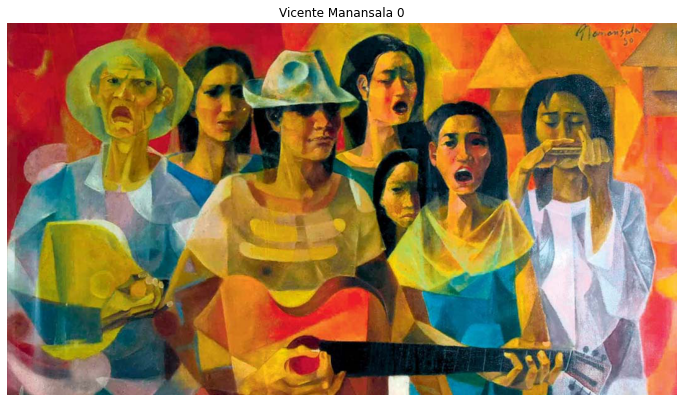

In [7]:
from sklearn.cluster import KMeans
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image

# directory
main_dir = "\\".join(os.getcwd().split("\\")[:-1]) # i:\Research\filipino art style GAN\methods
img_dir = os.path.join(main_dir, "data", "images")
img_name = "Vicente Manansala 0.jpg"
# img_name = "Spoliarium.jpg"
src_img = os.path.join(img_dir, img_name)
img_name  = img_name.split(".")[0]

# import and show painting
# raw_image = cv2.imread(src_img)
# raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
raw_image = Image.open(src_img)

def show_image(image, image_name = "Image", figsize=(12,8)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis("off")
    plt.title(image_name, )

show_image(raw_image, img_name)
# print(raw_image.shape)

## Color Extraction

In [8]:
# Preparing Image
image = np.reshape(raw_image,(-1, 3))
image.shape

(648000, 3)

### Dominant Color using Clustering

In [9]:
def clustering(image, n_clusters, print_info=False):
    kmeans = KMeans(n_clusters=n_clusters, random_state=2)
    kmeans.fit_predict(image)
    centers = kmeans.cluster_centers_.astype(int)

    # returns the labels for each pixel
    pxl = np.array(np.unique(kmeans.labels_, return_counts=True)[1], dtype=np.float32)
    pxl = pxl/image.shape[0] # gets the percentage

    # gets the dominant colors
    dom = [ [pxl[ix], centers[ix]] for ix in range(kmeans.n_clusters) ]
    dom = sorted(dom, reverse=True)

    # print
    if print_info:
        print("Cluster Centers:")
        for c in centers:
            print("\t", c)

        print("Dominant Colors")
        for d in dom:
            print("\t", d)

    return dom

def dominant_color_bar(color):
    color_bar = np.zeros((50,500,3), dtype="uint8")
    start = 0
    for c in color:
        width = round( (c[0])*color_bar.shape[1] )
        end = start+width
        color_bar[:,start:end, :] = c[1]
        start = end
    
    return color_bar

In [10]:
# get clustered colors
colors = clustering(image, n_clusters=10)
colors

[[0.20886265432098766, array([174, 132,  28])],
 [0.13660185185185186, array([115,  83,  35])],
 [0.12940277777777778, array([223, 167,  47])],
 [0.09106635802469136, array([138, 142, 140])],
 [0.08476234567901235, array([13, 22, 25])],
 [0.08087191358024691, array([178,  29,  34])],
 [0.07929166666666666, array([234, 104,  50])],
 [0.07579938271604938, array([35, 71, 71])],
 [0.07127777777777777, array([208, 206, 213])],
 [0.04206327160493827, array([ 19, 119, 140])]]

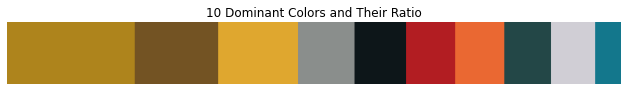

In [11]:
color_bar = dominant_color_bar(colors)

show_image(color_bar, "10 Dominant Colors and Their Ratio", figsize=(11, 5))

## Mood Analysis

color psychology on paintings

### Experiment on Color Instances

In [12]:
color_RGB_1 ={
    "Red": [255, 0, 0],
    "Yellow": [255, 255, 0],
    "Blue": [0, 0, 255],
    "Green": [0, 255, 0],
    "Orange": [255, 128, 0],
    "Purple": [128, 0, 128],
    "Pink": [255, 192, 203],
    "Brown": [100, 70, 36],
    "White": [255, 255, 255],
    "Black": [0, 0, 0],
    "Grey": [128, 128, 128],
}

# we only use four for now
color_meaning_1 ={
    "Red": ("excitement", "strength", "love", "energy"),
    "Yellow": ("creativity", "happiness", "warmth", "cheer"),
    "Blue": ("trust", "peace", "loyalty", "competence"),
    "Green": ("nature", "healing", "freshness", "growth"),
    "Orange": ("confidence", "success", "bravery", "sociability"),
    "Purple": ("wisdom", "luxury", "spirituality", "ambition"),
    "Pink": ("compassion", "sincerity", "sophistication", "sweet"),
    "Brown": ("dependable", "rugged", "trustworthy", "simple"),
    "White": ("clean", "simplicity", "innocence", "honest"),
    "Black": ("formality", "bold", "mystery", "security"),
    "Grey": ("detachment", "neutral", "compromising", "conservative"),
}

# smaller color sample for testing
color_RGB_2 ={
    "Red": [255, 0, 0],
    "Green": [0, 255, 0],
    "Blue": [0, 0, 255],
    "Yellow": [255, 255, 0],
    "Purple": [255, 0, 255],
    "Cyan": [0, 255, 255],
}
color_meaning_2 ={
    "Red": ("excitement", "strength", "love", "energy"),
    "Yellow": ("creativity", "happiness", "warmth", "cheer"),
    "Blue": ("trust", "peace", "loyalty", "competence"),
    "Green": ("nature", "healing", "freshness", "growth"),
    "Cyan": ("liveliness", "youth", "calmness", "health"),
    "Purple": ("wisdom", "luxury", "spirituality", "ambition"),
}



In [13]:
# uses the color dictionary from above without slicing the tone
# converts the dictionary to list
def conv_to_list(color_RGB, has_black_white=False, n_tones = 0):
    color_RGB_tone = []
    for key, value in color_RGB.items():
        # slice the colors for tones
        if n_tones > 0:
            R = value[0] / 5
            G = value[1] / 5
            B = value[2] / 5
            for n in range(n_tones):
                color_RGB_tone.append((key, [R*(n+1), G*(n+1), B*(n+1)]))
        # no slicing
        else:
            color_RGB_tone.append((key, value))

    # for black and white
    if has_black_white:
        color_RGB_tone.append(('Black', [0.0, 0.0, 0.0,]))
        color_RGB_tone.append(('White', [255.0, 255.0, 255.0,]))

    return color_RGB_tone

color_RGB_ls = conv_to_list(color_RGB_2, n_tones=0)
color_RGB_ls

[('Red', [255, 0, 0]),
 ('Green', [0, 255, 0]),
 ('Blue', [0, 0, 255]),
 ('Yellow', [255, 255, 0]),
 ('Purple', [255, 0, 255]),
 ('Cyan', [0, 255, 255])]

### Color Equivalence

In [14]:
# we use euclidean distances to get the similarity
# because we have color which has an RGB = 0, 0, 0 (black)

import numpy as np

def get_color_equivalent(colors, color_RGB, print_info = (False, False)):
    anchored_colors = []
    for color in colors: # iterrate clustered colors from the image
        color = color[1]
        nearest = float("inf") # declare high float value, get the nearest color
        # print(color)
        for (key, value) in color_RGB:
            distance = np.linalg.norm(color - value)
            # assign the closest color 
            if print_info[0]:
                print(f"{key}:{distance}")
            if distance < nearest:
                color_key = (key, value)
                nearest = distance
            
        if print_info[1]:
            print(f"{color_key[1]} = {color_key[0]} is nearest to {color} with distance of {nearest}")
        anchored_colors.append(color_key)
        
    return anchored_colors

In [15]:

color_equiv = get_color_equivalent(colors, color_RGB_ls, print_info =(False, True))

[255, 255, 0] = Yellow is nearest to [174 132  28] with distance of 149.91330828182
[255, 0, 0] = Red is nearest to [115  83  35] with distance of 166.4752233817393
[255, 255, 0] = Yellow is nearest to [223 167  47] with distance of 104.77117924314874
[0, 255, 255] = Cyan is nearest to [138 142 140] with distance of 212.22158231433485
[0, 0, 255] = Blue is nearest to [13 22 25] with distance of 231.41521125457592
[255, 0, 0] = Red is nearest to [178  29  34] with distance of 89.02808545621994
[255, 0, 0] = Red is nearest to [234 104  50] with distance of 117.29023829799307
[0, 255, 0] = Green is nearest to [35 71 71] with distance of 200.3047677914832
[255, 0, 255] = Purple is nearest to [208 206 213] with distance of 215.42748199800323
[0, 0, 255] = Blue is nearest to [ 19 119 140] with distance of 166.57430774282088


### Painting Color Emotion

In [16]:
def get_color_percentages(colors, color_equiv):
    # map the colors
    color_equiv_keys = [i[0] for i in color_equiv]
    color_map = []
    for idx, c in enumerate(colors):
        color_per = c[0]
        color_map.append((color_equiv_keys[idx], color_per))

    # get total percentage of color
    color_totals = {}
    for key, value in color_map:
        color_totals[key] = color_totals.get(key, 0) + value
    return color_totals


def get_dominant_emotions(color_list, color_meaning):
    # top color emotion
    # color_list = [key for key in color_totals][:n_emotions]
    emotions = []
    for key, value in color_meaning.items():
        if key in color_list:
            emotions.append((key, value))
    return emotions

def get_emotion_caption(colors, color_equiv, color_meaning = color_meaning_2, n_emotions=2):

    color_totals = get_color_percentages(colors, color_equiv)
    color_list = [key for key in color_totals][:n_emotions]
    color_dom_emo = get_dominant_emotions(color_list, color_meaning_2)


    # make sentence
    sentence = []
    for c in color_dom_emo:
        sentence.append(f" {', '.join(c[1])} because of the color {c[0]} which makes up about {color_totals[c[0]]:.2f}% of the image's color")
    
    caption = f"The {n_emotions} dominant colors of this image are {' and '.join(color_list)}."
    caption = " ".join((caption, "This image exudes", "; ".join(sentence)))

    return caption, color_dom_emo
caption, color_emo_map = get_emotion_caption(colors, color_equiv)
color_emo_map

[('Red', ('excitement', 'strength', 'love', 'energy')),
 ('Yellow', ('creativity', 'happiness', 'warmth', 'cheer'))]

### Show Image

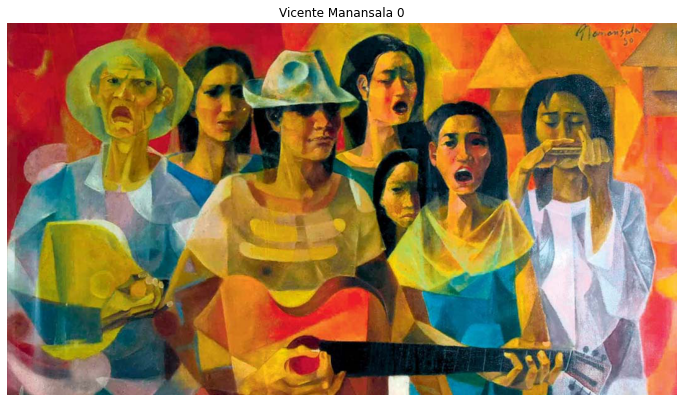

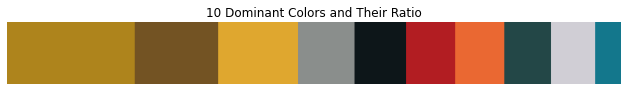

In [17]:
# show images
show_image(raw_image, img_name)
show_image(color_bar, "10 Dominant Colors and Their Ratio", figsize=(11, 5))

In [18]:
print(caption)

The 2 dominant colors of this image are Yellow and Red. This image exudes  excitement, strength, love, energy because of the color Red which makes up about 0.30% of the image's color;  creativity, happiness, warmth, cheer because of the color Yellow which makes up about 0.34% of the image's color


## Further Studies

**Color Psychology and Meaning**
- http://www.arttherapyblog.com/online/color-psychology-psychologica-effects-of-colors/#.YUG_zivitPY
- http://www.arttherapyblog.com/online/color-meanings-symbolism/#.YUG_5CvisuU
- https://www.invaluable.com/blog/colors-and-emotions/
- https://www.truevaluepaint.com/color-101/color-psychology
- https://www.verywellmind.com/color-psychology-2795824
- https://londonimageinstitute.com/how-to-empower-yourself-with-color-psychology/
- https://royalsocietypublishing.org/doi/10.1098/rsos.190741


**Color Difference**
- https://en.wikipedia.org/wiki/Color_difference

**Emotions with Color Palettes**
- https://core.ac.uk/download/pdf/153368581.pdf
- https://www.researchgate.net/publication/232048151_Learning_moods_and_emotions_from_color_combinations


**Emotions from Paint Strokes**

**Face Emotions**

# Art Style Transfer

In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

## Preparation

In [255]:
def load_image(image_path):
    max_dim = 512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)#Detects the image to perform apropriate opertions
    img = tf.image.convert_image_dtype(img, tf.float32)#converts image to tensor dtype

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)# Casts a tensor to float32.

    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)

    return img[tf.newaxis, :]

def show_image(image, image_name = "Image",):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  # print(image)
  # pil_image = Image.fromarray(image)
  # pil_image.save("hi.jpg")
  plt.imshow(image)
  plt.title(image_name)
  plt.axis("off")
  

# directory
img_dir = "i:\\Research\\filipino art style GAN\\methods\\data\\images"
style_image = load_image(os.path.join(img_dir, "José Joya painting", "José Joya painting4.jpg"))
content_image = load_image(os.path.join(img_dir, 'luneta_small.png'))

content_image.shape

TensorShape([1, 512, 327, 3])

tf.Tensor(
[[[0.84476876 0.8431373  0.8461029 ]
  [0.8472611  0.8533066  0.8533066 ]
  [0.8651224  0.863174   0.86546415]
  ...
  [0.7787305  0.8068651  0.8105871 ]
  [0.79304266 0.80660504 0.8182035 ]
  [0.7970402  0.8202724  0.82678133]]

 [[0.83996093 0.8429767  0.8486162 ]
  [0.8483208  0.85347444 0.8537199 ]
  [0.86417663 0.8614848  0.86085385]
  ...
  [0.8109616  0.8245022  0.83440626]
  [0.7977756  0.81370735 0.8242371 ]
  [0.8244047  0.840091   0.849165  ]]

 [[0.835858   0.83734435 0.8453704 ]
  [0.82811224 0.84495765 0.84955454]
  [0.85080445 0.85469824 0.85527116]
  ...
  [0.81285924 0.83481735 0.8400236 ]
  [0.8115544  0.82553285 0.83539784]
  [0.8256312  0.843288   0.8490295 ]]

 ...

 [[0.68406713 0.68406713 0.6700697 ]
  [0.68872625 0.68872625 0.68547714]
  [0.6964732  0.6964732  0.68740094]
  ...
  [0.6464969  0.6464969  0.6428624 ]
  [0.66780645 0.66780645 0.6674161 ]
  [0.6921198  0.6921198  0.67552364]]

 [[0.71744627 0.71744627 0.7036424 ]
  [0.7109263  0.7109263  0

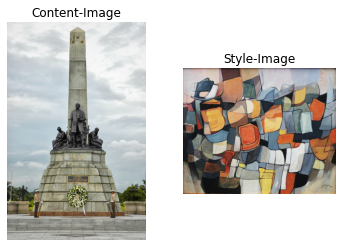

In [250]:
plt.subplot(1, 2, 1)
show_image(content_image, 'Content-Image')

plt.subplot(1, 2, 2)
show_image(style_image, 'Style-Image')

## Stylization Process

### Pretrained Model 

- this style transfer uses Tf arbritary image stylization
- **Further Studies**: Study other neural networks for style transfer and compare

In [22]:
# load pretrained model 
model_path = "I:\\Research\\filipino art style GAN\methods\\art style transfer\magenta_arbitrary-image-stylization-v1-256_2"
# model = hub.KerasLayer(hub.load(model_path))
model = hub.load(model_path)

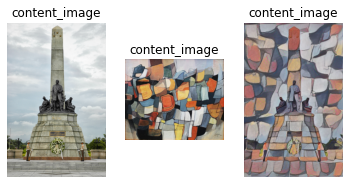

In [23]:
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0]

plt.subplot(1, 3, 1)
show_image(content_image, 'content_image')
plt.subplot(1, 3, 2)
show_image(style_image, 'content_image')
plt.subplot(1, 3, 3)
show_image(stylized_image, 'content_image')

# Emotion to Art Style
- combinig the two steps above

**Steps**
1. get color_emo_map

2. assign style image with the corresponding texts and create a dataset

3. type a sentence using emotive descriptions

4. get the image with the corresponding emotions

5. use the image for art style transfer

## make a database

In [140]:

# get the emotions of the reference images (style)
main_dir = "\\".join(os.getcwd().split("\\")[:-1])
data_dir = os.path.join(main_dir, "data", "sample_images")
data_csv_dir = os.path.join(main_dir, "data", "annotation_data")
content_dir = os.path.join(data_dir, "content")
style_dir = os.path.join(data_dir, "style")


content_imgs_ls = os.listdir(content_dir)
print(content_imgs_ls)
style_imgs_ls = os.listdir(style_dir)
print(style_imgs_ls)

['intramuros.jpg', 'manila_cityhall.jpg', 'rizal.jpg']
['Ang Kiukok painting22.jpg', 'Hernando R. Ocampo painting17.jpg', 'José Joya painting35.jpg', 'Vicente Manansala .jpg']


In [208]:
# smaller color sample for testing
color_RGB_2 ={
    "Red": [255, 0, 0],
    "Green": [0, 255, 0],
    "Blue": [0, 0, 255],
    "Yellow": [255, 255, 0],
    "Purple": [255, 0, 255],
    "Cyan": [0, 255, 255],
}

color_meaning_2 ={
    "Red": ("excitement", "strength", "love", "energy"),
    "Yellow": ("creativity", "happiness", "warmth", "cheer"),
    "Blue": ("trust", "peace", "loyalty", "competence"),
    "Green": ("nature", "healing", "freshness", "growth"),
    "Cyan": ("liveliness", "youth", "calmness", "health"),
    "Purple": ("wisdom", "luxury", "spirituality", "ambition"),
}

def get_image_color_emotions(image, n_clusters=10, n_tones=0, n_emotions=2):
    image = np.reshape(image,(-1, 3))

    # cluster color
    print("Clustering - Start")
    colors = clustering(image, n_clusters)

    print("Clustering - End")

    # slice or convert color sample dictionary to list
    color_RGB_ls = conv_to_list(color_RGB_2, n_tones=0)

    # dominant colors to equivalent emotion color
    color_equiv = get_color_equivalent(colors, color_RGB_ls, print_info =(False, False))

    print("Returning Color Emotions")
    # get the emotions
    _, color_emo_map = get_emotion_caption(colors, color_equiv)

    return [c[1] for c in color_emo_map]


In [217]:

# get all of the images' emotion
emo_feature = []
for img in style_imgs_ls:
    # set image
    print(f"Extracting Emotions in {img}")
    img = os.path.join(style_dir, img)
    img = Image.open(img)

    # get emotion
    emo = get_image_color_emotions(image = img,  n_clusters=10, n_emotions=2)

    # make emotion list
    emo_list = np.array(emo)
    emo_list = emo_list.flatten()
    
    # emo_list = [";;".join(x) for x in emo]
    emo_list = ";;".join(emo_list)

    # x = ";;".join(x)
    emo_feature.append(emo_list)


Extracting Emotions in Ang Kiukok painting22.jpg
Clustering - Start
Clustering - End
Returning Color Emotions
Extracting Emotions in Hernando R. Ocampo painting17.jpg
Clustering - Start
Clustering - End
Returning Color Emotions
Extracting Emotions in José Joya painting35.jpg
Clustering - Start
Clustering - End
Returning Color Emotions
Extracting Emotions in Vicente Manansala .jpg
Clustering - Start
Clustering - End
Returning Color Emotions


In [218]:

import pandas as pd
df = pd.DataFrame({"filename": style_imgs_ls, "emotion": emo_feature})
df.to_csv(os.path.join(data_csv_dir, "annot_emo_paint.csv"), index=False)
df

,filename,emotion
0,Ang Kiukok painting22.jpg,creativity;;happiness;;warmth;;cheer;;liveline...
1,Hernando R. Ocampo painting17.jpg,trust;;peace;;loyalty;;competence;;liveliness;...
2,José Joya painting35.jpg,excitement;;strength;;love;;energy;;creativity...
3,Vicente Manansala .jpg,creativity;;happiness;;warmth;;cheer;;nature;;...


## Get Image using Text

In [219]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string


def preprocess_text(text):
    # tokenization
    text_no_punc = " ".join("".join([" " if ch in string.punctuation else ch for ch in text]).split())
    text_token = word_tokenize(text_no_punc)

    # stopwords
    stop_words=set(stopwords.words("english"))
    text_filtered=[]
    for w in text_token:
        if w not in stop_words:
            text_filtered.append(w)

    # stemmer
    stemmer = SnowballStemmer("english")
    stemmed_words=[]
    for t in text_filtered:
        stemmed_words.append(stemmer.stem(t))


    return stemmed_words


In [220]:
def get_best_emo_match_img(df, text):
    # get the weight of each file
    # by finding the matching emotion words
    file_weight = {}
    for idx, row in df.iterrows():
        pt = preprocess_text(row["emotion"])
        
        # get matching string elements
        matching = [s for s in pt if any(xs in s for xs in text)]

        # create dictionary for matched emo keywords
        match_weight = len(matching)
        file_weight.update({row["filename"]: match_weight})
    
    # best_match = max(key for key, val in file_weight.items())
    best_match = max(file_weight, key=file_weight.get)
    print(file_weight)
    print(best_match)
    return best_match

In [221]:

def process_text_emo_art(image, input_text, df):
    prep_text = preprocess_text(input_text)
    style_filename = get_best_emo_match_img(df, prep_text)
    print(style_filename)
    style_image = load_image(os.path.join(style_dir, style_filename))
    stylized_image = model(tf.constant(image), tf.constant(style_image))[0]

    return stylized_image


In [222]:
df

,filename,emotion
0,Ang Kiukok painting22.jpg,creativity;;happiness;;warmth;;cheer;;liveline...
1,Hernando R. Ocampo painting17.jpg,trust;;peace;;loyalty;;competence;;liveliness;...
2,José Joya painting35.jpg,excitement;;strength;;love;;energy;;creativity...
3,Vicente Manansala .jpg,creativity;;happiness;;warmth;;cheer;;nature;;...


In [223]:
content_imgs_ls

['intramuros.jpg', 'manila_cityhall.jpg', 'rizal.jpg']

{'Ang Kiukok painting22.jpg': 4}
{'Ang Kiukok painting22.jpg': 4, 'Hernando R. Ocampo painting17.jpg': 0}
{'Ang Kiukok painting22.jpg': 4, 'Hernando R. Ocampo painting17.jpg': 0, 'José Joya painting35.jpg': 4}
{'Ang Kiukok painting22.jpg': 4, 'Hernando R. Ocampo painting17.jpg': 0, 'José Joya painting35.jpg': 4, 'Vicente Manansala .jpg': 5}
Vicente Manansala .jpg
Vicente Manansala .jpg


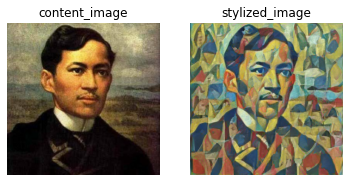

In [231]:

content_image = load_image(os.path.join(content_dir, "rizal.jpg"))
input_text = "make the image feel creativity happiness warmth cheer nature."

stylized_image = process_text_emo_art(content_image, input_text, df)


plt.subplot(1, 2, 1)
show_image(content_image, 'content_image')
plt.subplot(1, 2, 2)
show_image(stylized_image, 'stylized_image')
